<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/russell2019_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reproducing "Machine Learning and Geophysical Inversion: A Numerical Study" paper by Russell (2019) in Python

Yohanes Nuwara

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LambdaCallback

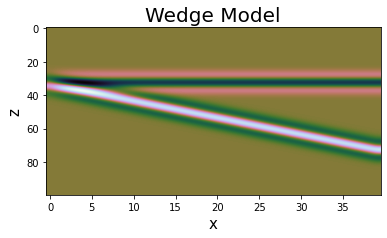

In [43]:
# Make wavelet
def Ricker(f, t):
  pift = np.pi * f * t
  wav = (1 - 2 * pift ** 2) * np.exp(-pift ** 2)
  return wav

t = np.linspace(-0.2,0.2,100)
w = Ricker(20, t)

# Make wedge model
length, depth = 40, 100
model = 1 + np.tri(depth, length, -depth//3)
model[:depth//3,:] = 0
rocks = np.array([[2700, 2750], [2400, 2450], [2800, 3000]])
earth = np.take(rocks, model.astype(int), axis=0)
imp = np.apply_along_axis(np.product, -1, earth)
rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])
synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=0, arr=rc)

plt.imshow(synth, cmap="cubehelix", aspect=0.2, interpolation='bicubic')
plt.title("Wedge Model", size=20)
plt.xlabel("x", size=15); plt.ylabel("z", size=15)
plt.show()

In [16]:
# Create a Neural Network 
model = Sequential()

model.add(Dense(2, activation='sigmoid', use_bias=False, input_shape=(2,)))
model.add(Dense(1, activation='linear', use_bias=False))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [3]:
# Create a callback that records weight of every epoch
weights_dict = {}
checkpoint = LambdaCallback \
( on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model.get_weights()}))

In [4]:
# Synthetic data: seismic trace
s = np.array([-0.1,  0.3, -0.3,  0.1])
x = np.ones(len(s))
X = np.vstack((x, s)).T

X

array([[ 1. , -0.1],
       [ 1. ,  0.3],
       [ 1. , -0.3],
       [ 1. ,  0.1]])

In [5]:
# Synthetic data: Reflectivity
y = np.array([0, 0.1, -0.1, 0]).T.reshape(-1,1)

y

array([[ 0. ],
       [ 0.1],
       [-0.1],
       [ 0. ]])

In [17]:
# Training with the model
callback = model.fit(X, y, epochs=5000, callbacks=[checkpoint])

Streaming output truncated to the last 5000 lines.
Epoch 2501/5000
1/1 [==============================] - 0s 11ms/step - loss: 5.1083e-04
Epoch 2502/5000
1/1 [==============================] - 0s 17ms/step - loss: 5.1082e-04
Epoch 2503/5000
1/1 [==============================] - 0s 4ms/step - loss: 5.1081e-04
Epoch 2504/5000
1/1 [==============================] - 0s 5ms/step - loss: 5.1080e-04
Epoch 2505/5000
1/1 [==============================] - 0s 8ms/step - loss: 5.1079e-04
Epoch 2506/5000
1/1 [==============================] - 0s 4ms/step - loss: 5.1078e-04
Epoch 2507/5000
1/1 [==============================] - 0s 10ms/step - loss: 5.1077e-04
Epoch 2508/5000
1/1 [==============================] - 0s 13ms/step - loss: 5.1076e-04
Epoch 2509/5000
1/1 [==============================] - 0s 4ms/step - loss: 5.1075e-04
Epoch 2510/5000
1/1 [==============================] - 0s 5ms/step - loss: 5.1074e-04
Epoch 2511/5000
1/1 [==============================] - 0s 6ms/step - loss: 5.1073e-04

In [18]:
# Compare true vs. predicted reflectivity
print("True reflectivity:")
print(y)

print("\nPredicted reflectivity:")
print(model.predict(X))

True reflectivity:
[[ 0. ]
 [ 0.1]
 [-0.1]
 [ 0. ]]

Predicted reflectivity:
[[-0.02869523]
 [ 0.08825724]
 [-0.09110817]
 [ 0.03154659]]


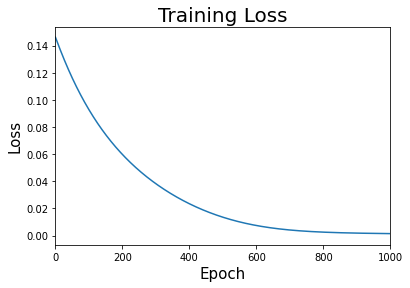

In [29]:
# Plot loss history
plt.plot(callback.history['loss'])
plt.xlim(0,1000)
plt.title("Training Loss", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("Loss", size=15)
plt.show()

In [20]:
# Print weights of layer 1
model.layers[0].get_weights()

[array([[-1.0630618 , -0.45149684],
        [-1.4469109 ,  1.4399436 ]], dtype=float32)]

In [21]:
# Print weights of layer 2
model.layers[1].get_weights()

[array([[-0.59749764],
        [ 0.39891523]], dtype=float32)]

In [22]:
# Retrieve weights
w1, w2 = [], []
for epoch,weights in weights_dict.items():
  # Weights of first layer
  w1.append(weights[0])
  # Weights of second layer
  w2.append(weights[1])

w1, w2 = np.array(w1), np.array(w2)

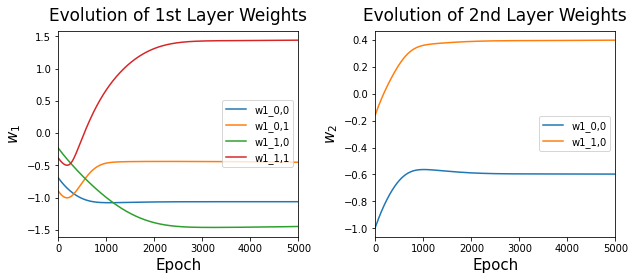

In [28]:
# Plot weights history
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
for i in range(2):
  for j in range(2):
    plt.plot(w1[:,i,j], label="w1_{},{}".format(i,j))
plt.xlim(0,5000)
plt.title("Evolution of 1st Layer Weights", size=17, pad=10)
plt.xlabel("Epoch", size=15); plt.ylabel("$w_1$", size=15)
plt.legend(loc='right')

plt.subplot(1,2,2)
for i in range(2):
  plt.plot(w2[:,i,0], label="w1_{},0".format(i))
plt.xlim(0,5000)
plt.title("Evolution of 2nd Layer Weights", size=17, pad=10)
plt.xlabel("Epoch", size=15); plt.ylabel("$w_2$", size=15)
plt.legend(loc='right')

plt.tight_layout(1.1)
plt.show()